11953

Index(['text', 'sentiment', 'emotion'], dtype='object')

11953

,text,sentiment,emotion
0,الله يعوضك خيرا مماخسرت ويوفقك من خيري الدنيا والاخرة,p,Sadness
1,من جدك هذا وانت استاذنا الله يعوضك اضعافها يارب,p,Sadness
2,الله يعوضك اضعاف ماخسرت ويرزقك بر ولدك وجميع الاخوان,p,Sadness
3,انما النصر صبر ساعه,p,Happiness


{'n', 'p', 't'}

sentiment
p    4558
t    3801
n    3594
Name: count, dtype: int64

3

11953

SaudiBERT_CNN, try:0


Some weights of BertModel were not initialized from the model checkpoint at faisalq/SaudiBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9562 [00:00<?, ? examples/s]

Map:   0%|          | 0/2391 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
50,0.484200,0.251840,0.905897,0.908466,0.905591,0.905295
100,0.269600,0.189804,0.926391,0.928543,0.925021,0.925631
150,0.235000,0.199751,0.923881,0.927345,0.921915,0.922767
200,0.100900,0.271234,0.911752,0.913037,0.914468,0.911174
250,0.113400,0.237572,0.920954,0.921270,0.923739,0.920947
300,0.094200,0.165193,0.937683,0.937556,0.939101,0.937732
350,0.046800,0.176897,0.943538,0.944068,0.942415,0.943022
400,0.048500,0.174496,0.937265,0.937641,0.936030,0.936470
450,0.057000,0.195300,0.937683,0.938090,0.938092,0.936507
500,0.026600,0.201492,0.939774,0.939202,0.939277,0.939238


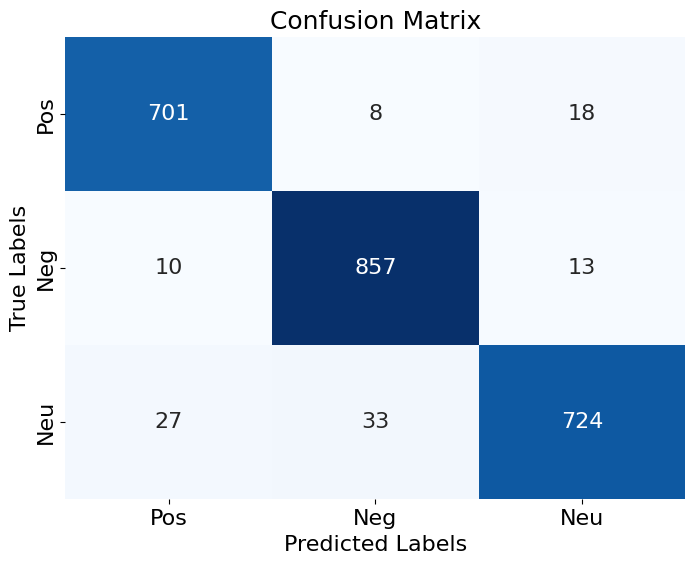

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import os
import seaborn as sns
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import tensorflow as tf
import pandas as pd
import pyarabic.araby as araby
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset, concatenate_datasets
import torch
import torch.nn as nn
from transformers import AutoModel, TrainingArguments, Trainer, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)



df = pd.read_csv('Tadawul_Sentiment_Emotions_Analysis.csv', encoding='utf-8', engine='python', sep='\t')



df.fillna('', inplace=True)  
display(len(df))


display(df.columns)
display(len(df))
display(df[:4])



classes = set(df['sentiment'].values)
display(classes)

c = df['sentiment'].value_counts()
display(c)

df['sentiment'] = df['sentiment'].astype('category')
df['label'] = df['sentiment'].cat.codes

df = df[['text', 'label']]
classes_num = len(classes)
display(classes_num)
display(len(df))


max_sequence_length = 128



class BertLSTMModel(nn.Module):
    def __init__(self, model_name, num_labels, hidden_dim=128, num_layers=2):
        super(BertLSTMModel, self).__init__()
        
        self.bert = AutoModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)
        self.num_labels = num_labels
    
    def forward(self, input_ids, attention_mask, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = lstm_output[:, -1, :]  
        logits = self.classifier(lstm_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )



class BertCNNModel(nn.Module):
    def __init__(self, model_name, num_labels, num_filters=100, filter_sizes=[3, 4, 5]):
        super(BertCNNModel, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, self.bert.config.hidden_size)) for fs in filter_sizes
        ])
        self.classifier = nn.Linear(len(filter_sizes) * num_filters, num_labels)
        self.num_labels = num_labels


    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = bert_outputs.last_hidden_state.unsqueeze(1) 

        conv_outputs = [torch.relu(conv(sequence_output)).squeeze(3) for conv in self.convs]
        pooled_outputs = [torch.max(output, 2)[0] for output in conv_outputs]
        cat_output = torch.cat(pooled_outputs, 1)
        
        logits = self.classifier(cat_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )



models = [ 
      
        'SaudiBERT_CNN',
    
]


seeds = [1]


for model_name in models:
    for seed in seeds:
        ds = Dataset.from_pandas(df)
        ds = ds.train_test_split(test_size=0.2, seed = seed)
        if seed==0:
            display(ds)
        for i in range(1):
            print(f'{model_name}, try:{i}')
                  
            if(model_name == 'SaudiBERT_LSTM'):
                tokenizer = AutoTokenizer.from_pretrained('faisalq/SaudiBERT')
                model = BertLSTMModel(model_name='faisalq/SaudiBERT', num_labels=classes_num).to('cuda')       
            elif(model_name == 'SaudiBERT_CNN'):
                tokenizer = AutoTokenizer.from_pretrained('faisalq/SaudiBERT')
                model = BertCNNModel(model_name='faisalq/SaudiBERT', num_labels=classes_num).to('cuda')
            else:
                tokenizer = AutoTokenizer.from_pretrained(model_name)                
                model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                  num_labels=classes_num).to('cuda')                                                 
            dataset_train = ds['train']
            dataset_validation = ds['test']                                                    
            
          
    
            def preprocess_function(examples):
                return tokenizer(examples['text'], truncation=True, padding="max_length",
                                max_length=max_sequence_length)
            
            
            dataset_train = dataset_train.map(preprocess_function, batched=True) 
            dataset_validation = dataset_validation.map(preprocess_function, batched=True)  
            
           
            
            def compute_metrics(eval_pred):
                logits, labels = eval_pred
                predictions = np.argmax(logits, axis=-1)    
                acc = accuracy_score(labels, predictions)        
                f1 = f1_score(labels, predictions, average='macro')  
                precision = precision_score(labels, predictions, average='macro')
                recall = recall_score(labels, predictions, average='macro')
               
                return {'accuracy': acc, 'precision': precision, 'recall':recall, 'f1_score': f1}
    
    
            
            
            epochs = 8
            save_steps = 10000 #save checkpoint every 10000 steps
            batch_size = 64
            
            training_args = TrainingArguments(
                output_dir = 'bert/',
                overwrite_output_dir=True,
                num_train_epochs = epochs,
                per_device_train_batch_size = batch_size,
                per_device_eval_batch_size = batch_size,
                save_steps = save_steps,
                save_total_limit = 1, #only save the last 5 checkpoints
                fp16=True,
                learning_rate = 5e-5,  # 5e-5 is the default
                logging_steps = 50, #50_000
                evaluation_strategy = 'steps',
                # evaluate_during_training = True,
                eval_steps = 50
                
            )
            
            trainer = Trainer(
                model = model,
                args = training_args,
                train_dataset=dataset_train,
                eval_dataset=dataset_validation,
                compute_metrics = compute_metrics
            )
            
            
            trainer.train()




true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for sample in dataset_validation:

        inputs = tokenizer(sample['text'], truncation=True, padding="max_length",
                                   max_length=max_sequence_length, return_tensors="pt").to('cuda')
        
        true_label = sample['label']
        true_labels.append(true_label)

        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
        predicted_labels.append(prediction)

labels = ['Pos', 'Neg', 'Neu']

cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, annot_kws={"size": 16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)

plt.show()
